# Introducción al MEF en una dimensión

*Alejandro Alonso Membrilla*

En este cuaderno se expone la solución al ejercicio obligatorio sobre la resolución numérica de un problema con condiciones de tipo Robin. 

Aplicaremos el método sugerido en el comentario previo al enunciado del ejercicio, basado en el segundo método para resolver el problema de tipo Neumann con condiciones a la derecha del intervalo visto en las clases de prácticas. Como se verá, esta técnica calcula directamente la solución al problema (sin necesidad de descomponerla en una solución homogénea y un término más sencillo) añadiendo ciertos términos al vector de cargas y a la matriz de rigidez.

In [1]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
import math
%matplotlib inline 
import matplotlib.pyplot as plt

# Definición de las funciones de base del E.F.

In [2]:
t,z,xL,xR,yL,yR = sp.symbols('t,z,xL,xR,yL,yR')
def linea(z,xL,yL,xR,yR):
    """linea que pasa por los puntos (xL,yL) y (xR,yR)"""
    return yL+(z-xL)*(yL-yR)/(xL-xR)

In [3]:
def l1(t):
    """primera func. de base del E.F. de Lagrange P1 en 1D"""
    return 1-t

def l2(t):
    """segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return t

In [4]:
def dl1(t):
    """derivada de la primera func. de base del E.F. de Lagrange P1 en 1D"""
    return -1

def dl2(t):
    """derivada de la segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return 1

In [5]:
def Finv(z,a,b):
    """afinidad entre cada subintervalo de la partición 
        y el intervalo unidad"""
    return (z-a)/(b-a)

def dFinv(z,a,b):
    """ derivada de la afinidad Finv"""
    return 1/(b-a)

In [6]:
def wi(z,x,i):  # en los nodos interiores
    """funciones de base del E.F. de Lagrange P1 unidimensional"""
    if (x[i-1]<=z)*(z<=x[i]):
        valor = l2(Finv(z,x[i-1],x[i]))
    elif (x[i]<=z)*(z<=x[i+1]):  
        valor = l1(Finv(z,x[i],x[i+1]))
    else:
        valor = 0
    return valor

def w0(z,x):  # en el extremo izquierdo del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo izquierdo"""
    if (x[0]<=z)*(z<=x[1]):
        valor = l1(Finv(z,x[0],x[1]))
    else:
        valor = 0
    return valor

def wn(z,x):  # en el extremo derecho del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo derecho"""
    # recuérdese que x[-1] y x[-2] indican respectivamente el último y penúltimo nodos
    if (x[-2]<=z)*(z<=x[-1]):  
        valor = l2(Finv(z,x[-2],x[-1])) 
    else:
        valor = 0
    return valor

In [7]:
def f(z):
    return np.sin(z)

# Planteamiento del problema diferencial de 2º orden a resolver

Supongamos que queremos resolver un problema de contorno de segundo orden muy sencillo, con condiciones de tipo Dirichlet en los extremos de cierto intervalo $[a,b]$; pongamos por ejemplo

$$-y''(x) = f(x), \; x\in [a,b]\\
y(a) = y_a,\quad y(b)=y_b$$

para cierta función $f(x)$ continua en dicho intervalo. Tomemos por ejemplo $f(x)=\sin(x),\; x\in[0,10]$ para empezar.

In [8]:
z = sp.Symbol('z')
y   = sp.Function('y')
def L(y,z): # usaremos la variable z como variable independiente
    """operador diferencial que define la ec. dif."""
    return -sp.diff(y(z),z,2)
L(y,z)  

-Derivative(y(z), (z, 2))

In [9]:
# z = sp.Symbol('z')
def f(z):
    """función del segundo término de la ec. diferencial"""
    return sp.sin(z)

sp.Eq(L(y,z),f(z)) #  ec. diferencial que estamos considerando 

Eq(-Derivative(y(z), (z, 2)), sin(z))

# Caso de condiciones mixtas (de tipo Robin)

#### Posibilidad de proponer como ejercicio este caso

Resolveremos finalmente la misma ecuación diferencial anterior, pero con alguna de las condiciones de tipo Robin (o mixto), aunque la otra siga siendo de tipo Dirichlet en alguno de los dos extremos de cierto intervalo $[a,b]$, con lo cuál seguimos teniendo asegurada la unicidad de la correspondiente solución; pongamos por ejemplo (con $|\alpha_b|+|\beta_b|\neq 0$)

$$-y''(x) = f(x), \; x\in [a,b]\\
y(a) = y_a,\quad \alpha_b y(b)+\beta_b y'(b)=\widehat{y}_b$$

para cierta función $f(x)$ continua en dicho intervalo. Seguiremos tomando $f(x)=\sin(x),\; x\in[0,10]$ como antes.

**Comentario:** Nótese que si $\beta_b = 0$ entonces la condición de tipo Robin se reduciría a una condición de tipo Dirichlet estandard ($y(b)=\frac{\widehat{y}_b}{\alpha_b}$), mientras que si por el contrario $\alpha_b = 0$ entonces dicha condición se convierte en una condición de tipo Neumann ($y'(b)=\frac{\widehat{y}_b}{\beta_b}$); así pues, consideraremos $\alpha_b, \beta_b\neq 0$ a partir de ahora.

De manera completamente equivalente se podría haber planteado el problema con condiciones de tipo Robin en el extremo de la izquierda:
$$\alpha_a y(a)+\beta_a y'(a)=\widehat{y}_a, \quad y(b) = y_b $$

Buscaremos soluciones aproximadas de la siguiente forma  
$$\widetilde{y}_h(x) = y_0 w_0(x)+ \sum_{j=1}^{n}y_j w_j(x)\equiv y_a w_0(x)+\widetilde{z}_h(x),$$ con el valor $y_0=y_a$ fijado a partir de la condición de tipo Dirichlet dada en ese extremo izquierdo del intervalo, mientras que tendremos que dejar $y_n$ libre, por la condición de tipo mixto impuesta en el otro extremo del intervalo.  Como es habitual, usaremos las funciones de base $w_i(x),\, i=0,1,\ldots, n$ para este E.F. de Lagrange lineal.

En este caso pues, también se deberá satisfacer la correspondiente formulación variacional del problema correspondiente a una condición de tipo Robin: $\alpha_b y(b)+\beta_b y'(b)=\widehat{y}_b$ en el extremo derecho del intervalo $[a,b]$ (con $\beta_b\neq 0$), a saber

$$\mathcal{A}(\widetilde{y}_h,w_i)
+w_i(b)\widetilde{y}_h(b)\frac{\alpha_b}{\beta_b}
=\mathcal{B}_{f}(w_i)+w_i(b)\frac{\widehat{y}_b}{\beta_b},\; \forall i =1,\ldots,n$$

donde ahora podríamos escribir $\widetilde{\mathcal{A}}(w_i,w_j)\equiv\mathcal{A}(w_i,w_j)
+w_i(b)\, w_j(b)\,\frac{\alpha_b}{\beta_b}$  y
$\widetilde{\mathcal{B}}_{f}(w_i)\equiv\mathcal{B}_{f}(w_i)+ w_i(b)\frac{\widehat{y}_b}{\beta_b}$; pero claramente estos nuevos  sumandos sólo cambiarán algo cuando ni $w_i(b)$ ni $w_j(b)$ se anule; es decir para los índices $i=j=n$.

Usando además la bilinealidad de la forma cuadrática $\mathcal{A}$ nos quedaría $\forall i =1,\ldots,n$ que

$$\widetilde{\mathcal{B}}_{f}(w_i)= \int_a^b f(x)w_i(x)\,dx + w_i(b)\frac{\widehat{y}_b}{\beta_b}\\
= \widetilde{\mathcal{A}}(y_a w_0+ \sum_{j=1}^{n}y_j w_j,w_i) \\
=y_a \mathcal{A}(w_0,w_i)+w_0(b)\,w_i(b)\,\frac{\alpha_b}{\beta_b}\\
+\sum_{j=1}^{n}y_j \mathcal{A}(w_j,w_i)
+w_i(b)\,w_j(b)\, \frac{\alpha_b}{\beta_b}$$

pero claramente todos los elementos $w_i(b)=w_j(b)=0,\; \forall i=1,\ldots,n-1$ y $\mathcal{A}(w_0,w_i)$ también serán nulos salvo en todo caso el correspondiente a $i=1$
$$\mathcal{A}(w_0,w_1)=-\frac{1}{x_1-x_0}.$$

Así pues, tan sólo tendríamos que modificar el primer elemento del vector de cargas, sumándole el siguiente término:

$$-y_a\mathcal{A}(w_0,w_1) = +\frac{y_a}{x_1-x_0}$$

En cuanto a los términos $w_i(b)\,w_j(b)\,\frac{\alpha_b}{\beta_b}$, nótese que todos se anularían también, salvo el caso $i=j=n$; por lo tanto esto provocaría que cambie tan sólo el último elemento de la diagonal de la matriz de rígidez: 
$\widetilde{\mathcal{A}}(w_n,w_n) = \mathcal{A}(w_n,w_n) +\,\frac{\alpha_b}{\beta_b}$.


**Ejercicio (obligatorio):** Terminar de implementar el código correspondiente a la resolución numérica aproximada de un problema como este con condiciones de contorno de tipo Robin, en uno de los extremos del intervalo y resuelva el correspondiente problema con $a=0$, $b=M=\max_\limits{1\leq i\leq 8}{d_i}$, $y_a=d_2$, $\alpha_b = \max{(d_3,1)}$, $\beta_b = \max{(d_4,1)}$ e $\widehat{y}_b = d_5$, si el último dígito de su DNI es par o 0; o bien $a=0$, $b=M$, $y_b=d_2$, $\alpha_a = \max{ (d_3,1)}$, $\beta_a =\max{(1, d_4)}$ e $\widehat{y}_a = d_5$, si el último dígito de su DNI es impar, siendo $d_i$ (con $i=1,\ldots 8$) el dígito de su DNI o pasaporte situado en la posición i-ésima.

In [10]:
solgen = sp.dsolve(sp.Eq(-y(z).diff(z,2), f(z)))
print(solgen)
solgen

Eq(y(z), C1 + C2*z + sin(z))


Eq(y(z), C1 + C2*z + sin(z))

In [11]:
# Para calcular la solución exacta representaremos nuestros parámetros 
# de forma simbólica y construiremos un método general
a,b,α,β = sp.symbols('a,b,α,β')
ya,yb = sp.symbols('ya,yb')
C1,C2 = sp.symbols('C1,C2')

In [12]:
print(sp.diff(C1 + C2*z + sp.sin(z),z)) 

C2 + cos(z)


In [13]:
ecs = (C1 + C2*z + sp.sin(z)).subs({z:a})-ya, (α*(C1 + C2*z + sp.sin(z))+β*(C2 + sp.cos(z))).subs({z:b})-yb
ecs  # continuar a partir de aquí

(C1 + C2*a - ya + sin(a), -yb + α*(C1 + C2*b + sin(b)) + β*(C2 + cos(b)))

In [14]:
c1c2 = sp.solve(ecs,[C2,C1])

In [15]:
c1c2

{C2: ya*α/(a*α - b*α - β) - yb/(a*α - b*α - β) - α*sin(a)/(a*α - b*α - β) + α*sin(b)/(a*α - b*α - β) + β*cos(b)/(a*α - b*α - β),
 C1: a*yb/(a*α - b*α - β) - a*α*sin(b)/(a*α - b*α - β) - a*β*cos(b)/(a*α - b*α - β) - b*ya*α/(a*α - b*α - β) + b*α*sin(a)/(a*α - b*α - β) - ya*β/(a*α - b*α - β) + β*sin(a)/(a*α - b*α - β)}

In [16]:
# Sustituimos C1 y C2 en la solución general de la ecuación
C1_val = (a*(-yb + α*sp.sin(b) + β*sp.cos(b)) + (ya - sp.sin(a))*(b*α + β))/(-a*α + b*α + β)
C2_val = (ya*α - yb - α*sp.sin(a) + α*sp.sin(b) + β*sp.cos(b))/(a*α - b*α - β)
print(solgen.subs({C1:C1_val,C2:C2_val}))

Eq(y(z), z*(ya*α - yb - α*sin(a) + α*sin(b) + β*cos(b))/(a*α - b*α - β) + (a*(-yb + α*sin(b) + β*cos(b)) + (ya - sin(a))*(b*α + β))/(-a*α + b*α + β) + sin(z))


In [17]:
print(solgen.subs(c1c2))

Eq(y(z), a*yb/(a*α - b*α - β) - a*α*sin(b)/(a*α - b*α - β) - a*β*cos(b)/(a*α - b*α - β) - b*ya*α/(a*α - b*α - β) + b*α*sin(a)/(a*α - b*α - β) - ya*β/(a*α - b*α - β) + z*(ya*α/(a*α - b*α - β) - yb/(a*α - b*α - β) - α*sin(a)/(a*α - b*α - β) + α*sin(b)/(a*α - b*α - β) + β*cos(b)/(a*α - b*α - β)) + β*sin(a)/(a*α - b*α - β) + sin(z))


In [18]:
# Definimos una función que evalúa la expresión analítica 
def yexacta(z,a,b,ya,yb,α,β):
    """solución exacta del problema tomado como ejemplo"""
    return z*(ya*α - yb - α*sp.sin(a) + α*sp.sin(b) + β*sp.cos(b))/(a*α - b*α - β) + (a*(-yb + α*sp.sin(b) \
        + β*sp.cos(b)) + (ya - sp.sin(a))*(b*α + β))/(-a*α + b*α + β) + sp.sin(z)

In [19]:
# Sustituimos los parámetros siguiendo las indicaciones dadas en el enunciado
dni = [7,5,5,7,7,3,9,4]
a = 0; b = max(dni);
ya = dni[1]; yb = dni[4];
α = max(dni[2],1);  β = max(dni[3],1);
yex = yexacta(z,a,b,ya,yb,α,β)
yex

-z*(7*cos(9) + 5*sin(9) + 18)/52 + sin(z) + 5

In [20]:
sp.diff(yex,z,2)

-sin(z)

In [21]:
sp.N(yex.subs({z:a}))

5.00000000000000

In [22]:
sp.N((α*yex+β*sp.diff(yex,z,1)).subs({z:b}))

7.00000000000000

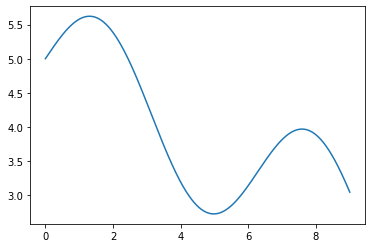

In [23]:
nx = 10; x = np.linspace(a,b,nx+1)
nxx = 1000; xx = np.linspace(a,b,nxx+1)

yyexacta = [yexacta(z,a,b,ya,yb,α,β) for z in xx] 
plt.plot(xx,yyexacta);

### Ensamblaje de la matriz de rigidez

In [24]:
# Matriz local
a00 = sp.integrate((dl1(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])
a01 = sp.integrate(dl1(Finv(z,xL,xR))*dl2(Finv(z,xL,xR))*dFinv(z,xL,xR)**2,[z,xL,xR])
a11 = sp.integrate((dl2(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])

Agen = sp.Matrix([[a00,a01],[a01,a11]])
Agen = sp.simplify(Agen) # y esta sería la correspondiente matriz

h_e = sp.Symbol('h_e') # ahora sustituiremos xR-xL por he, una
Agen = Agen.subs({xL-xR:-h_e, -xL+xR:h_e}) # longitud genérica
Agen

Matrix([
[ 1/h_e, -1/h_e],
[-1/h_e,  1/h_e]])

In [25]:
A = np.zeros((nx,nx),dtype=float)
np.shape(A)
# print(A)

(10, 10)

In [26]:
for i in range(1,nx): # ¡Atención con los índices en Python!
# hemos empezado con los elementos de la diagonal principal de la 
# matriz de rigidez, con índices desde 0 hasta nx-2.   
    A[i-1,i-1] = Agen[1,1].subs({h_e:x[i]-x[i-1]})+Agen[0,0].subs({h_e:x[i+1]-x[i]})
A[nx-1,nx-1]   = Agen[1,1].subs({h_e:x[nx]-x[nx-1]}) + α/β
# pero el caso nx-1 es especial y hay que definirlo aparte

In [27]:
for i in range(1,nx): # ahora nos encargamos de la diagonal inferior
    A[i-1,i] = Agen[0,1].subs({h_e:x[i+1]-x[i]})
    A[i,i-1] = A[i-1,i] # y de la superior por simetría
print(A)

[[ 2.22222222 -1.11111111  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-1.11111111  2.22222222 -1.11111111  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -1.11111111  2.22222222 -1.11111111  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -1.11111111  2.22222222 -1.11111111  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.11111111  2.22222222 -1.11111111
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.11111111  2.22222222
  -1.11111111  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.11111111
   2.22222222 -1.11111111  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.11111111  2.22222222 -1.11111111  0.        ]
 [ 0.          0.          0.          0

In [28]:
B = np.zeros(nx) # Ahora empezamos a construir el array correspondiente
print(B)         # al vector de términos independientes del sist. lineal
                 # con valores nulos en un primer momento.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
from scipy.integrate import quad

for i in range(1,nx):  # Atención: ¡cuidado con los índices en Python!
    intizda = quad(lambda z:f(z)*l2(Finv(z,x[i-1],x[i])),x[i-1],x[i])
    intdcha = quad(lambda z:f(z)*l1(Finv(z,x[i],x[i+1])),x[i],x[i+1])
    B[i-1] = intizda[0] + intdcha[0]
B[nx-1] = quad(lambda z:f(z)*l2(Finv(z,x[nx-1],x[nx])),x[nx-1],x[nx])[0]  
print(B)

[ 0.65867354  0.81887608  0.35936953 -0.37210072 -0.82197256 -0.64979195
  0.01413825  0.66736891  0.81554808  0.29138434]


In [30]:
B[0]  = B[0]  + ya/(x[1]-x[0]) # modificamos el primer elemento
B[-1] = B[-1] + yb/β # así como el último del vector de cargas B
B[0],B[-1]

(6.214229098196412, 1.2913843445476447)

In [31]:
Y = np.linalg.solve(A,B) # y ya podemos resolver el nuevo sistema

In [32]:
Y  # cuya solución nos aportará los coeficientes que necesitábamos

array([5.54651128, 5.50021638, 4.716933  , 3.61021705, 2.83839175,
       2.80634176, 3.35910452, 3.89914286, 3.83854918, 3.04396223])

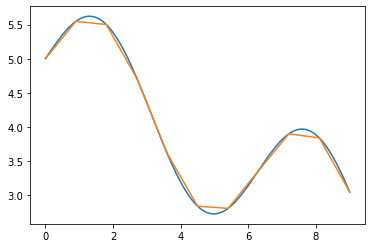

In [33]:
yy = np.zeros(len(xx)) # con estos valores ya podemos construir la
yy = np.array([sum([wi(z,x,i)*Y[i-1] for i in range(1,nx)]) for z in xx])
# sumatoria, a la que añadimos las dos func. de base de los extremos
yy = yy +    ya*np.array([w0(z,x) for z in xx]) # izquierdo y
yy = yy + Y[-1]*np.array([wn(z,x) for z in xx]) # derecho
# multiplicadas por los coeficientes apropiados
plt.plot(xx,yyexacta); # para poder recuperar las condiciones
plt.plot(xx,yy); # de contorno del problema de partida